# Import Libraries and Load Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import networkx as nx

from bokeh.io import show, output_notebook
from bokeh.models import Plot, Range1d, MultiLine, Circle, HoverTool, TapTool, BoxSelectTool
from bokeh.models.graphs import from_networkx, NodesAndLinkedEdges, EdgesAndLinkedNodes
from bokeh.palettes import Spectral4

In [ ]:
orders = pd.read_csv('../dataset/orders.csv')
products = pd.read_csv('../dataset/products.csv')
category = pd.read_csv('../dataset/departments.csv')
aisle = pd.read_csv('../dataset/aisles.csv')
ordered_products = pd.read_csv('../dataset/order_products_prior.csv')

# Merging all csv into one dataframe

Understanding the dataset which we have, will proceed to merge the dataframes in accordance to the respective secondary keys then perform cleaning and EDA

In [ ]:
def merge_dataframe(df1, df2, on_column):
    df = pd.merge(df1, df2, how = 'left', on = on_column)
    return df

In [ ]:
product_with_category = merge_dataframe(products, category, 'department_id')

In [ ]:
product_with_category_aisle = merge_dataframe(product_with_category, aisle, 'aisle_id')

In [ ]:
ordered_product_full = merge_dataframe(ordered_products, product_with_category_aisle, 'product_id')

In [ ]:
full_df = merge_dataframe(orders, ordered_product_full, 'order_id')

# Check and Clean Final DataFrame

In [ ]:
full_df.shape

We have over 3 million rows and 15 columns, we will go through the columns one by one. Before doing that, we will define a function to prints out the basic information for the column and decide if there is a need to explore more on the respective columns after these information are printed out.

In [ ]:
def check_column(df, column, print_unique = False):
    print('{} has {} values'.format(column, df[column].count()))
    print('{} has {} unique values'.format(column, df[column].nunique()))
    print('{} has {} null values'.format(column, df[column].isnull().sum()))
    print('{} data type is {}'.format(column, df[column].dtypes))
    if print_unique == True:
        print("{}'s unique value are \n {}".format(column, df[column].unique()))

## Order ID

In [ ]:
check_column(full_df, 'order_id')

- We have over 3421083 unique orders, we have an adequate number of orders to build our recommender system. 
- There are no null values and the data type is correct

## User ID

In [ ]:
check_column(full_df, 'user_id')

- We have 206209 unique users, which is adequate to build our recommender system
- There are no null values and data type is correct

## Eval Set

Evaluation set is the label detailing if where the data belongs to the test, train or prior set.

In [ ]:
check_column(full_df, 'eval_set', print_unique = True)

We have 3 unique values for evaluations set, we shall explore more and take a look at the sample of each category

In [ ]:
full_df[full_df['eval_set'] == 'train'].sample(3)

In [ ]:
full_df[full_df['eval_set'] == 'test'].sample(3)

In [ ]:
full_df[full_df['eval_set'] == 'prior'].sample(3)

- Only eval_set columns with value prior has the full details 
- __Just show to explain, delete for submission(because we only merge order_products_prior, we still have order_products_test)__
- We will only keep rows where columns eval_set is prior

In [ ]:
full_df = full_df[full_df['eval_set'] == 'prior']

## Order Number - revisit first line to better phrase

Order number shows how many orders the user made inclusive of the current order. 

For example order ID 0001 is the first order made by user 001, the order number will be 1. If user 001 made a second order with order_id 0002, the order number for that order will be 2. 

In [ ]:
check_column(full_df, 'order_number', print_unique = True)

- There are 99 unique values from 0-99
- Instacart only keeps tracks of repeated orders until counts of 99

## Order Day of Week (order_dow)

Order day of week tells us the day of the week the order is made. 0 means it is Sunday, 1 means it is Monday and so on.

In [ ]:
check_column(full_df, 'order_dow', print_unique = True)

- Order day of the week has 7 unique values which makes sense as we have 7 days a week.
- There are no null values and the data type is correct

## Order Hour of Day

Order hour of the day tells us the hour of the day the order is made. It is in 24 hour format. 0 means 12AM, 13 means 1PM

In [ ]:
check_column(full_df, 'order_hour_of_day', print_unique = True)

- Order hour of the day has 24 unique values which is reasonable as we have 24 hours a day
- There are no null values and the data type is correct 
- __Convert this to date time????__

## Days Since Prior Order

Days since prior order shows the number of days that has passed since the last order made by the client

In [ ]:
check_column(full_df, 'days_since_prior_order', print_unique = True)

- Day since prior order has 31 unque values
- The data type is float
- Noticed that we have 2078068 null values, we shall explore more on this

In [ ]:
full_df[full_df['days_since_prior_order'].isnull()][['order_number', 'days_since_prior_order']].sample(3)

In [ ]:
full_df[full_df['days_since_prior_order'].notnull()][['order_number', 'days_since_prior_order']].sample(3)

- Null values are when order number is 1
- Instacart only keep track of days since prior order for repeated clients.
- We shall let the column remain as it is, with its null values and data type for now. Instacart may wish to drill down for more granularity to calculate this column base on the time of the day the new order is made. 
- __Create one more column date of last order? days_since_prior_order - today's date????__


## Product ID and Product Name

Product Name shows the name of the product and Product ID shows the ID corresponding to the said product. We shall look at both of them at the same time.

In [ ]:
check_column(full_df, 'product_id')

In [ ]:
check_column(full_df, 'product_name')

- We have the same total number of values for both product name and product id
- They both have the same number of unique values, which shows that there are no discrepencies amongst them
- There are no missing values for both of them
- Product ID's data type can be converted to integer as it is all whole numbers and do not require to be a float

In [ ]:
full_df['product_id'] = full_df['product_id'].astype('int64')

## Add to Cart Order

Add to cart order refers to the order that product is added into the cart for that order id.

For example, user 001 added banana, followed by orange then beer into the cart for order 001.
- Banana's add to cart order will be 1
- Orange's add to cart order will be 2
- Beer's add to cart order will be 3

In [ ]:
check_column(full_df, 'add_to_cart_order', print_unique = True)

- Add to Cart Order has no null values
- It has 145 unique values running from 1 to 145. The number is shows no discrepencies as there are no zero or negative number.
- We can see that the 145 is highest number of products bought in a single order
- Data type is float, as we are looking at number of products which will be whole number, we shall convert it to integer

In [ ]:
full_df['add_to_cart_order'] = full_df['add_to_cart_order'].astype('int64')

## Reordered

Reordered shows whether the product had been ordered before by the same user.

In [ ]:
check_column(full_df, 'reordered', print_unique = True)

- This column is a binary column
- If the product have been ordered by the same client before, this will be a 1, if not, it will be a 0
- Data type is float, we shall convert them to integer as binaries do not have to be float

In [ ]:
full_df['reordered'] = full_df['reordered'].astype('int64')

## Department ID and Department

Department shows the name of the product's category, and department id shows the corresponding ID. We shall look at them together

In [ ]:
check_column(full_df, 'department_id')

In [ ]:
check_column(full_df, 'department', print_unique = True)

- We have the same total number of values for both department and department id
- They both have the same number of unique values, which is how it should be
- There are no missing values for both of them
- Department IDs are whole number and can be converted into integer
- Most of the values in department are self explanatory except for other, missing and bulk, we shall look into them in more details

In [ ]:
full_df['department_id'] = full_df['department_id'].astype('int64')

### Missing

In [ ]:
full_df[full_df['department'] == 'missing']['product_name'].nunique()

In [ ]:
full_df[full_df['department'] == 'missing'][['product_name', 'department', 'aisle']].sample(5)

- Instacart have 49677 total products and amongst them 1255 have their department and aisle missing (approximately 2.5%)
- Product name with department columns missing also has their aisle column missing 
- __We are unable to infer the department based on aisle, the other way we can do it is to go through the product name and manually tag the department column__
- We will drop these rows

In [ ]:
full_df.drop(full_df.index[full_df['department'] == 'missing'], axis = 0, inplace = True)

- __before drop we have 32434489 rows, after drop we have 32365344 rows we still have 99% of our data__ 

### Bulk

In [ ]:
full_df[full_df['department'] == 'bulk']['product_name'].nunique()

In [ ]:
full_df[full_df['department'] == 'bulk'][['product_name', 'department', 'aisle']].sample(3)

Bulk means dried fruits and vegetables

- Total products we have is 49677, and we have 38 products in the bulk category(approximately 0.07%)
- Bulk are for products in the bulk grain and dried goods category
- We will let them remain as it is

### Other

In [ ]:
full_df[full_df['department'] == 'other']['product_name'].nunique()

In [ ]:
full_df[full_df['department'] == 'other'][['product_name', 'department', 'aisle']].sample(3)

- Total products we have is 49677, and we have 548 products in the others category(approximately 1.1%)
- Other are for which do not fall into rest of the categories
- As others is a legitimate category, we will let them remain as it is

## Aisle ID and Aisle

Aisle shows the a more drilled down category for the product when compared to department, and aisle id shows the corresponding ID. For example packaged produce and fresh vegetables which are values in the aisle column are a more drilled down category for department named produce.

We shall look at them together.

In [ ]:
check_column(full_df, 'aisle_id')

In [ ]:
check_column(full_df, 'aisle', print_unique = True)

- We have the same total number of values for both aisle and aisle id
- They both have the same number of unique values, which is correct
- There are no missing values for both of them
- Aisle IDs are whole number and can be converted into integer
- Values in aisle do not show any unusual values.

In [ ]:
full_df['aisle_id'] = full_df['aisle_id'].astype('int64')

# Save Cleaned Data Frame

In [ ]:
full_df.to_csv('../dataset/cleaned/combined_cleansed.csv', index = False)

In [ ]:
full_df.head(15)

## Visualisation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import networkx as nx

from bokeh.io import show, output_notebook
from bokeh.models import Plot, Range1d, MultiLine, Circle, HoverTool, TapTool, BoxSelectTool
from bokeh.models.graphs import from_networkx, NodesAndLinkedEdges, EdgesAndLinkedNodes
from bokeh.palettes import Spectral4

In [2]:
full_df = pd.read_csv('../dataset/cleaned/combined_cleansed.csv')

In [3]:
full_df.columns

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'product_id',
       'add_to_cart_order', 'reordered', 'product_name', 'aisle_id',
       'department_id', 'department', 'aisle'],
      dtype='object')

In [4]:
full_df['order_id'].nunique()

3214669

In [5]:
def subplot_histograms(dataframe, list_of_columns, ylabel = 'Probability Density Function'):
    nrows = int(np.ceil(len(list_of_columns)/2)) # Makes sure you have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize = (15, 5)) # You'll want to specify your figsize
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        sns.distplot(dataframe[column].dropna(), ax = ax[i], bins = 5, fit = norm, kde = False)
        mean = dataframe[column].mean()
        ax[i].set_title('{} DISTRIBUTION'.format(str.upper(list_of_columns[i]).replace('_', ' ')), fontsize = 20)
        ax[i].set_xlabel(str.upper(list_of_columns[i]).replace('_', ' '), fontsize = 20)
        ax[i].tick_params(labelsize=20)
        ax[i].set_ylabel(ylabel, fontsize = 20)
        ax[i].axvline(mean, color = 'r')
        ax[i].grid(axis = 'y', alpha = 0.5) # set grid line, alpha is transparency
        fig.tight_layout()

## Data Distribution

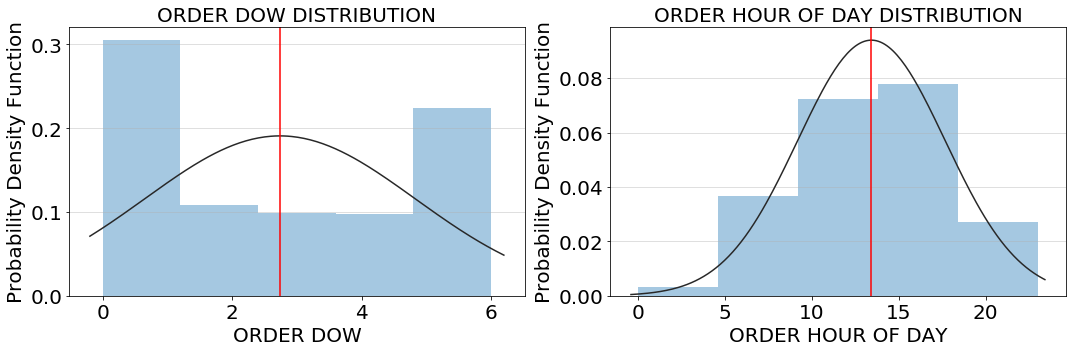

In [6]:
subplot_histograms(full_df, ['order_dow', 'order_hour_of_day'])

- The plot on the left shows the distribution for order day of the week, we can see that most order are placed between Friday and Monday
- The plot on the right shows the distribution for order hour of the day, we can see that more new orders are placed between 9AM - 5PM

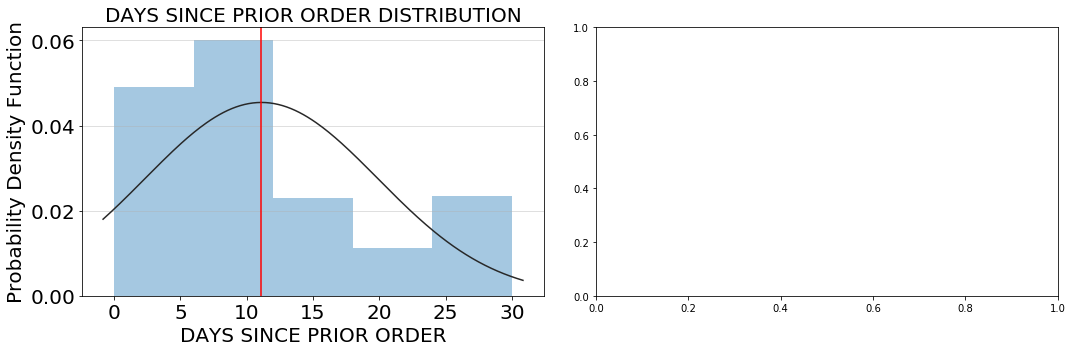

In [7]:
subplot_histograms(full_df, ['days_since_prior_order'])

- The plot above shows the distribution of days since prior order. We can see that most repeated customers will place another order within 12 days after their last order

In [8]:
def draw_barplot (df, groupby, target, title, xlabel = None,  ylabel = 'Number of Unique Orders', rotation = 0, sort = False):
    fig, ax = plt.subplots(figsize=(15, 7))
    ax.grid(False)
    
    if sort == True:
        df.groupby([groupby])[target].nunique().sort_values(ascending = False).head(21).plot(color = 'r')
        df.groupby([groupby])[target].nunique().sort_values(ascending = False).head(21).plot(kind = 'bar', color = 'b')
    else:
        df.groupby([groupby])[target].nunique().plot.bar(color = 'b')
        df.groupby([groupby])[target].nunique().plot(color = 'r')
    
    ax.set_title(title, fontsize = 20)
    ax.set_xlabel(xlabel, fontsize = 20)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = rotation)
    xmin,xmax = ax.get_xlim()
    ax.set_xlim([xmin - 0.5, xmax + 0.5])
    ax.set_ylabel(ylabel, fontsize = 20)
    for p in ax.patches:
        ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), 
                    ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', size = 8)

## Purchasing Behaviour

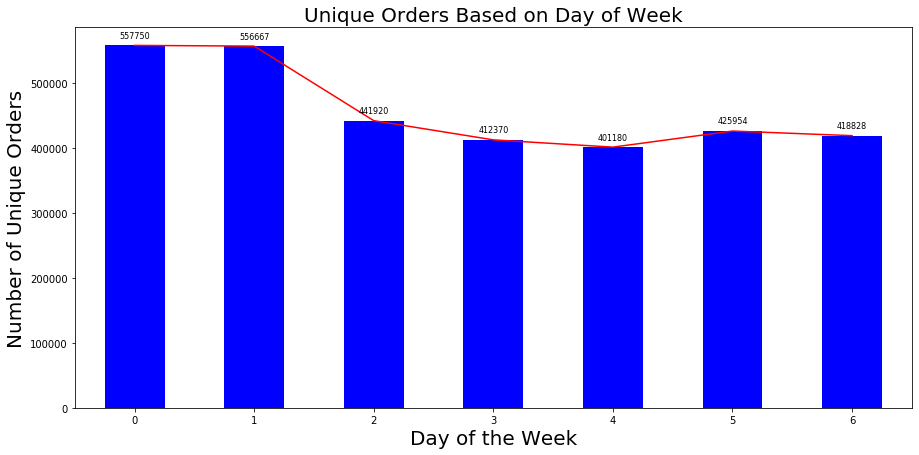

In [9]:
draw_barplot(full_df, 'order_dow', 'order_id', 'Unique Orders Based on Day of Week', xlabel = 'Day of the Week')

- The above plot shows the count of unique orders broken down by the day of the week. It depicts the same picture as our histogram which shows that most unique orders comes in between Fridays and Sundays

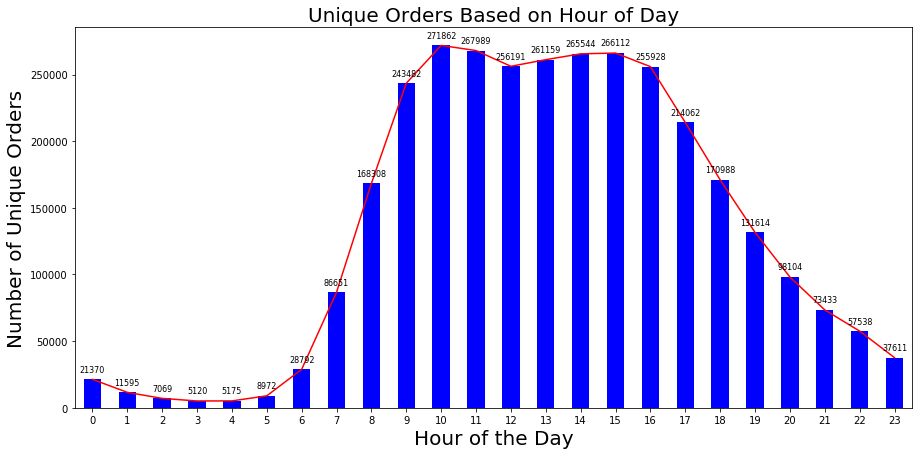

In [10]:
draw_barplot(full_df, 'order_hour_of_day', 'order_id', 'Unique Orders Based on Hour of Day', xlabel = 'Hour of the Day')

- The above plot shows the count of unique orders broken down by the how of day. It sings the same tune as our histogram which shows that most new orders comes in between 9AM to 5PM

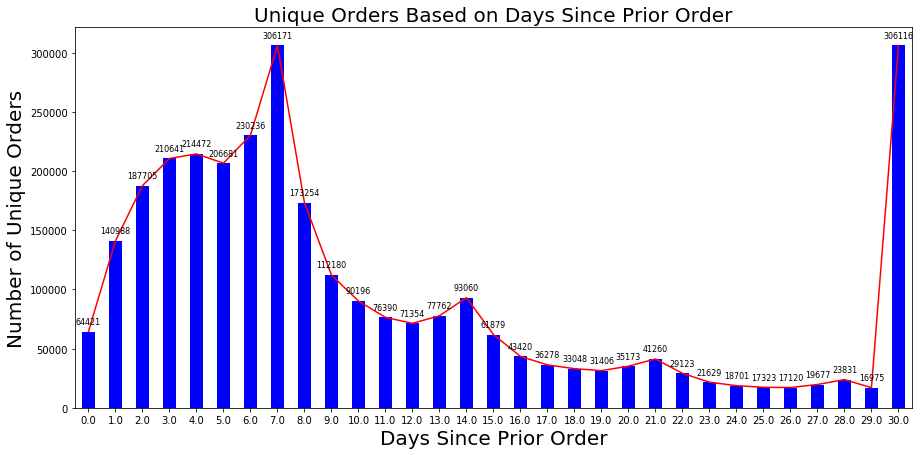

In [11]:
draw_barplot(full_df, 'days_since_prior_order', 'order_id', 'Unique Orders Based on Days Since Prior Order', xlabel = 'Days Since Prior Order')

- From the above plot we can see that there are usually an increase in the number of orders every 7 days
- We can infer from this the most of the clients replenish their consumables on a weekly or fortnightly basis
- Another trend we can see is that most of the repeated orders come in within 7 days since the last order
- The spike at day 30 could be for clients who are not regular customers but have placed at least 2 orders

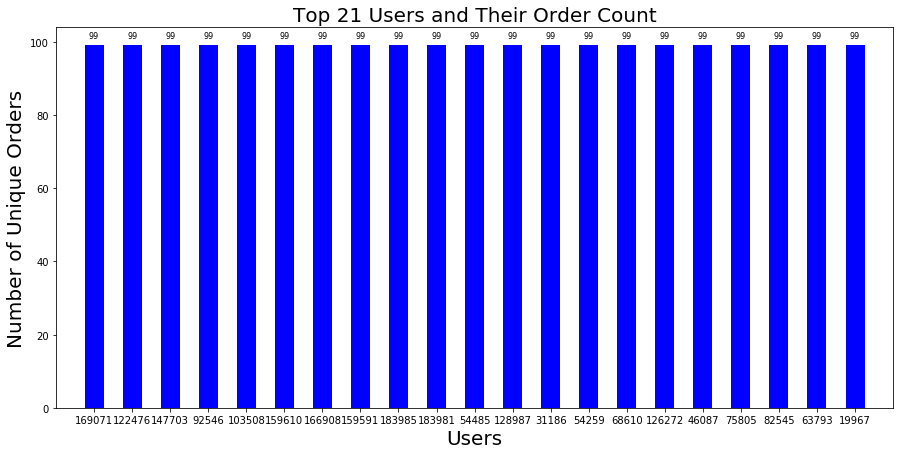

In [12]:
draw_barplot(full_df, 'user_id', 'order_id', 'Top 21 Users and Their Order Count', xlabel = 'Users', sort = True)

- The above plot shows the top 21 users and their order count. We can see that it is all capped at 99 orders. 
- The provided data only keep tracks of a maximum of 99 unique orders for the same user 

## Products Insights

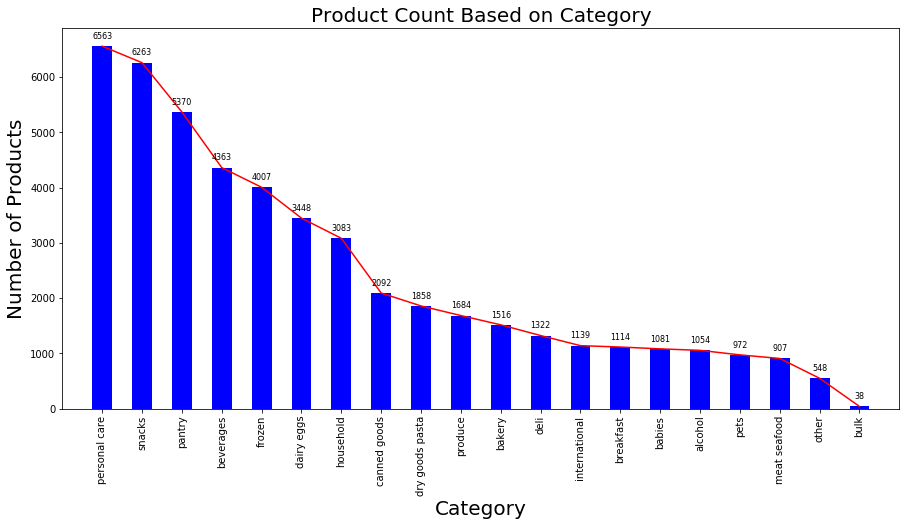

In [13]:
draw_barplot(full_df, 'department', 'product_id', 'Product Count Based on Category', ylabel = 'Number of Products', xlabel = 'Category', rotation = 90, sort = True)

- From the above plot that categories and their unique products
- We can see that personal care carries the most type of products while bulk carry the least

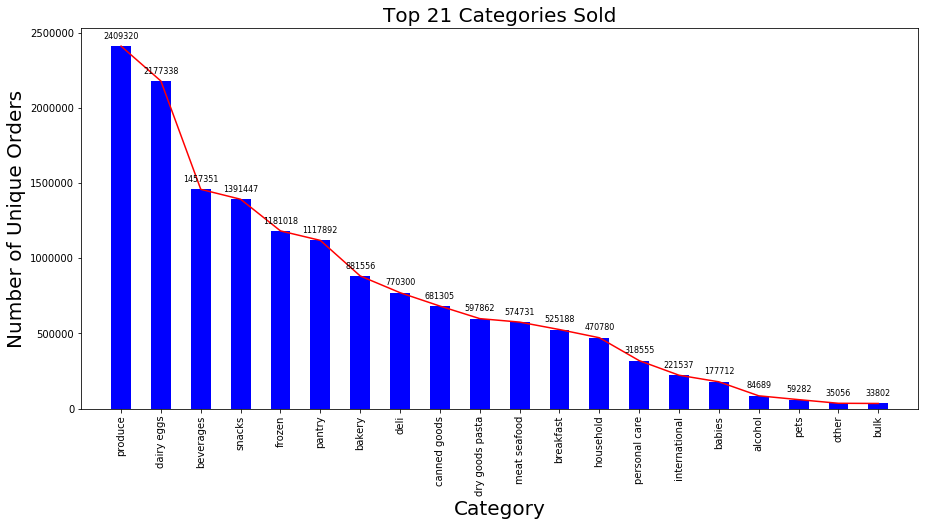

In [14]:
draw_barplot(full_df, 'department', 'order_id', 'Top 21 Categories Sold', xlabel ='Category', rotation = 90, sort = True)

- The above plot shows the top 21 categories of products which are sold the most.
- The top 3 categories are produce, diary eggs and beverages which are perishable. Being perishables and non-durable, it explains why they clock the most number of orders 
- Notice that although we carry the most different type of products for personal care but the number of it being sold is not the most. At one glance we might think that we should lower the stocks for this categiry, however, this phenomena can be due to products in personal care is more durable and do not require as much replenishing compared to non-durable products. We should conduct a more indepth look into this category to get more insights on this occurence

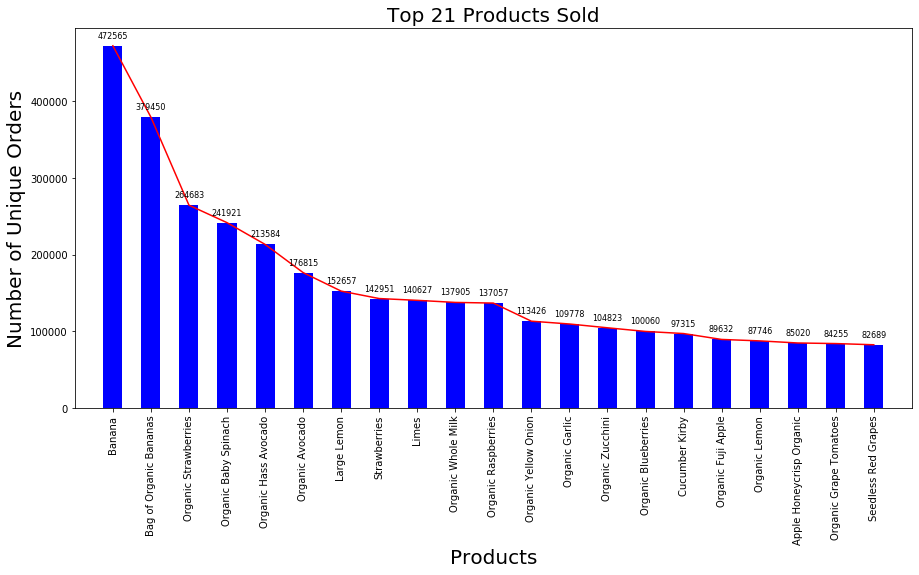

In [15]:
draw_barplot(full_df, 'product_name', 'order_id', 'Top 21 Products Sold', xlabel = 'Products', rotation = 90, sort = True)

- The above shows the top 21 products which are sold the most
- We can see that most of the products are organic products or fruits

## Correlation

In [16]:
def subplot_scatter(dataframe, column_x, column_y, list_of_titles):
    nrows = int(np.ceil(len(column_x)/2)) # Makes sure you have enough rows
    #ncols = int(len(column_x))
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize = (15, 28))
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, (columnx, columny) in enumerate(zip(column_x, column_y)): # Gives us an index value to get into all our lists
        sns.regplot(x = columnx, y = columny, data = dataframe, ax = ax[i], color ='b')
        ax[i].set_title(list_of_titles[i], fontsize = 12)
        ax[i].set_xlabel(column_x[i].replace('_', ' ').title(), fontsize = 12)
        ax[i].set_ylabel(column_y[i].replace('_', ' ').title(), fontsize = 12)
        #ax[i].legend(column_x, loc = 'upper right')
        ax[i].grid(axis = 'y', alpha = 0.5) # set grid line, alpha is transparency